In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

In [3]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [3]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output= model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output= model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [4]:
import torchvision.models as models

# Descargar el modelo Inception preentrenado
model = torchvision.models.densenet121(pretrained=True)

# Imprimir la arquitectura del modelo
print(model)

/home/pepe/Documents/AppRepos/CEIA/VCII/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pepe/Documents/AppRepos/CEIA/VCII/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/pepe/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 11.8MB/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
for param in model.parameters():
    param.requires_grad = False

# Modificar la capa completamente conectada para adaptarla
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 10)

# Imprimir la arquitectura del modelo modificado
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224
    transforms.ToTensor(),           # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar las imágenes
])

train_set = torchvision.datasets.ImageFolder(root='./train_dataset', transform=data_transform)
test_set = torchvision.datasets.ImageFolder(root='./test_dataset', transform=data_transform)

# Crear DataLoader
animals_train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
animals_test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fn = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": animals_train_loader, "valid": animals_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="data_aug/densenet121"),
          "valid": SummaryWriter(log_dir="data_aug/densenet121")}

history = train(model.to("cpu"), optimizer, loss_fn, metric, data, 20, writer)

Epoch: 1/20 - Train loss 2.197679 - Train Accuracy 0.158139 - Valid Loss 1.937472 - Valid Accuracy 0.304733
Epoch: 2/20 - Train loss 1.748086 - Train Accuracy 0.458788 - Valid Loss 1.541782 - Valid Accuracy 0.611402
Epoch: 3/20 - Train loss 1.413560 - Train Accuracy 0.683044 - Valid Loss 1.226810 - Valid Accuracy 0.786372
Epoch: 4/20 - Train loss 1.156755 - Train Accuracy 0.817252 - Valid Loss 1.008337 - Valid Accuracy 0.873453
Epoch: 5/20 - Train loss 0.961621 - Train Accuracy 0.871431 - Valid Loss 0.828219 - Valid Accuracy 0.901707
Epoch: 6/20 - Train loss 0.811487 - Train Accuracy 0.899380 - Valid Loss 0.692840 - Valid Accuracy 0.926479
Epoch: 7/20 - Train loss 0.697479 - Train Accuracy 0.915210 - Valid Loss 0.601152 - Valid Accuracy 0.933826
Epoch: 8/20 - Train loss 0.610808 - Train Accuracy 0.924074 - Valid Loss 0.522535 - Valid Accuracy 0.938155
Epoch: 9/20 - Train loss 0.542111 - Train Accuracy 0.930821 - Valid Loss 0.465284 - Valid Accuracy 0.943735
Epoch: 10/20 - Train loss 0.

In [9]:
PATH = "./model/densenet_model.pt"
torch.save(model, PATH)

In [3]:
import json
import matplotlib.pyplot as plt

In [10]:

HISTORY_FILE_PATH = "./output/desnenet_history.json"
# Writing dictionary to JSON file
with open(HISTORY_FILE_PATH, 'w') as json_file:
    json.dump(history, json_file)

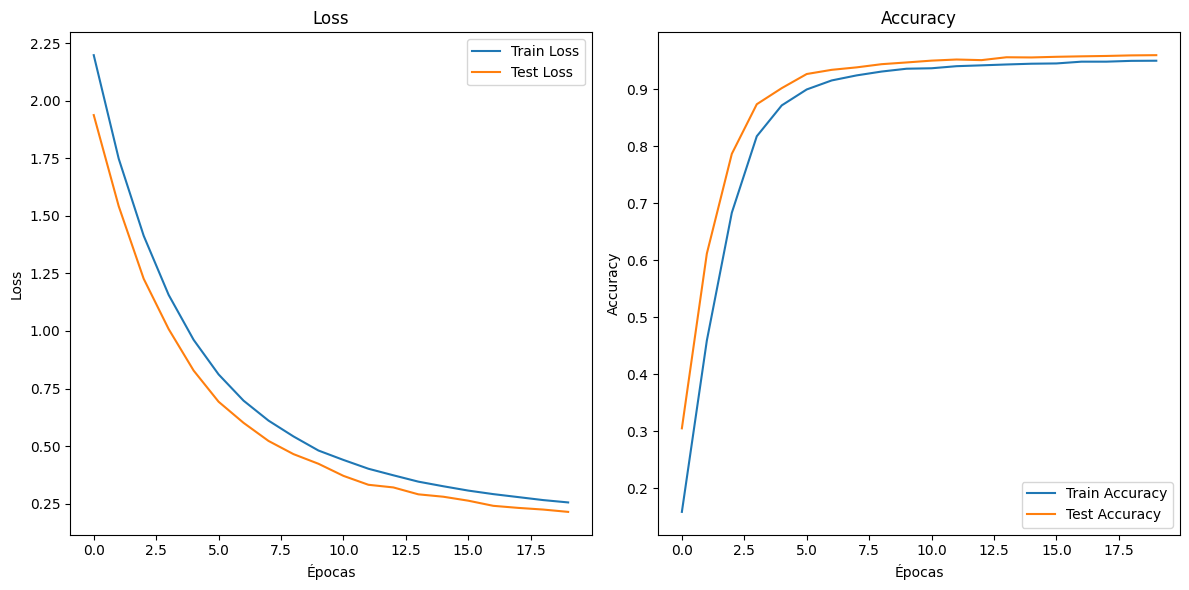

In [5]:
with open("C:/Users/cbureu/Documents/Repo/CEIA/VCII/output/densenet_history.json", "r") as file:
    densenet_history = json.load(file)

train_loss = densenet_history["train_loss"]
train_acc = densenet_history["train_acc"]
valid_loss = densenet_history["valid_loss"]
valid_acc = densenet_history["valid_acc"]

# Crear subplots para loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Test Loss")

plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(valid_acc, label="Test Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
modelo_ruta = "./model/densenet_model.pt"

modelo_cargado = torch.load(modelo_ruta, map_location=torch.device('cpu'))

modelo_cargado.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
from PIL import Image
from torchvision.io import read_image

image_paths = [
    "./test_dataset/elefante/e83db30d2df5073ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg",
    "./test_dataset/farfalla/eb34b70720fd023ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg",
    "./test_dataset/pecora/e836b20a2cfc073ed1584d05fb1d4e9fe777ead218ac104497f5c978a6eab2b0_640.jpg",
    "./test_dataset/cane/OIP-SUtvtTATeX3-WuP61EaWpAHaKL.jpeg",
    "./test_dataset/gatto/126.jpeg",
    "./test_dataset/scoiattolo/OIP-ZFxY-A1tVIi381bQsUvuSAAAAA.jpeg",
    "./test_dataset/gallina/6.jpeg",
    "./test_dataset/cavallo/OIP-_j8NKLs1XQyY3TgGUcNc8gHaGl.jpeg",
    "./test_dataset/mucca/OIP-h9nqwXuCD4MelYpAuWYf_QAAAA.jpeg",
]

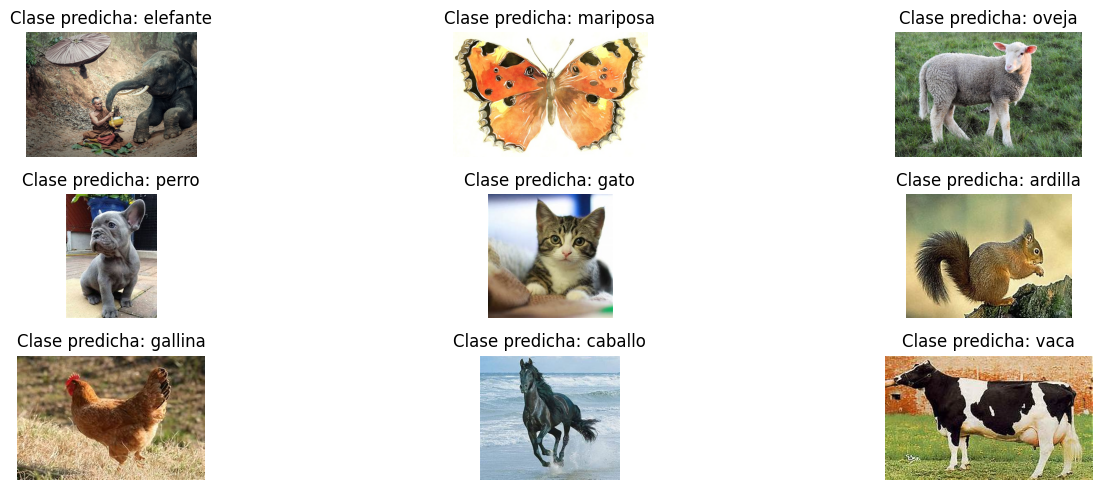

In [22]:
translate = {0: "perro", 1: "caballo", 2: "elefante", 3: "mariposa", 4: "gallina", 5: "gato", 6: "vaca", 7: "oveja", 8: "araña", 9: "ardilla"}

input_images = []

# Preprocesar las imágenes y realizar las predicciones
for image_path in image_paths:
    # Cargar la imagen
    image = Image.open(image_path)
    
    # Aplicar transformaciones de datos
    input_image = data_transform(image).unsqueeze(0)
    
    # Realizar la predicción
    with torch.no_grad():
        output = modelo_cargado(input_image)
        predicted_class = torch.argmax(output, dim=1).item()
    
    # Mapear el índice de clase predicho a su nombre
    if predicted_class in translate:
        class_name = translate[predicted_class]
    else:
        class_name = "Clase no mapeada"
    
    # Almacenar la imagen y su clase predicha
    input_images.append((image, class_name))

# Mostrar las imágenes y las clases predichas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5))

for i, (image, class_name) in enumerate(input_images):
    row_idx = i // 3
    col_idx = i % 3
    
    axes[row_idx, col_idx].imshow(image)
    axes[row_idx, col_idx].set_title(f"Clase predicha: {class_name}")
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()